In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import diffoptics as optics

# Point Spread Functions

In [2]:
# Helpers

def gaussian_kernel_1d(size, sigma=1):
    x = torch.arange(-size/2, size/2, 1)
    return 1 / (sigma * np.sqrt(2 * np.pi)) * torch.exp(-.5 * (x / sigma) ** 2)

def gaussian_kernel_2d(size, sigma=1):
    return torch.outer(gaussian_kernel_1d(size, sigma=sigma),
                       gaussian_kernel_1d(size, sigma=sigma))

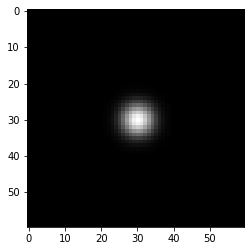

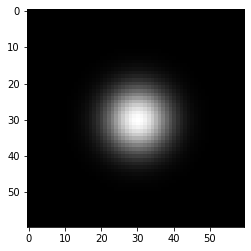

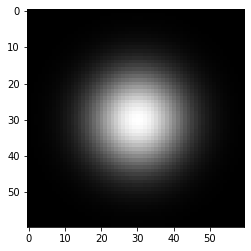

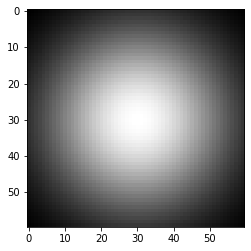

In [3]:
# Toy gaussian Psfs

for sigma in [3, 6, 9, 18]:
    kernel = gaussian_kernel_2d(60, sigma=sigma)
    plt.imshow(kernel.numpy(), cmap='gray')
    plt.show()

In diffoptics, psfs are depth-dependent (position along the optical axis), and height-dependent (vertical position on the sensor).

Point spread functions are represented by dictionaries where the primary keys are tuple that indicate the depth at which the psfs apply, while the secondary keys indicate the height on the sensor on which the psfs apply.

In [4]:
inf = int(1e15)

# No psf
no_psfs = {}

# A psf that applies to all depth and all the sensor
psfs = {'data' : {(-inf, inf) : {(0, inf) : optics.PSF(gaussian_kernel_2d(45, sigma=3))}}}

# A psf that is depth-dependent
psfs = {'data' : {(-inf, -1) : {(0, inf) : optics.PSF(gaussian_kernel_2d(45, sigma=3))},
                  (-1, 1) : {(0, inf) : optics.PSF(gaussian_kernel_2d(45, sigma=5))},
                  (1, inf) : {(0, inf) : optics.PSF(gaussian_kernel_2d(45, sigma=3))}}}

# A psf that is height-dependent
psfs = {'data' : {(-inf, inf) : {(0, 1000) : optics.PSF(gaussian_kernel_2d(45, sigma=3)),
                                 (1000, 2000) : optics.PSF(gaussian_kernel_2d(45, sigma=4)),
                                 (2000, inf) : optics.PSF(gaussian_kernel_2d(45, sigma=5))}}}

# A psf that is depth-dependent and height-dependent
psfs = {'data' : {(-inf, -1) : {(0, 1000) : optics.PSF(gaussian_kernel_2d(45, sigma=3)),
                                (1000, 2000) : optics.PSF(gaussian_kernel_2d(45, sigma=4)),
                                (2000, inf) : optics.PSF(gaussian_kernel_2d(45, sigma=5))},
                  (-1, 1) : {(0, 1000) : optics.PSF(gaussian_kernel_2d(50, sigma=3)),
                             (1000, 2000) : optics.PSF(gaussian_kernel_2d(50, sigma=4)),
                             (2000, inf) : optics.PSF(gaussian_kernel_2d(50, sigma=5))},
                  (1, inf) : {(0, 1000) : optics.PSF(gaussian_kernel_2d(45, sigma=3)),
                              (1000, 2000) : optics.PSF(gaussian_kernel_2d(45, sigma=4)),
                              (2000, inf) : optics.PSF(gaussian_kernel_2d(45, sigma=5))}}}

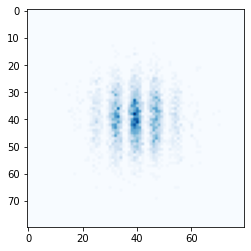

In [5]:
# No psfs

# Creating a scene
f = 0.05
m = 0.15
lens = optics.PerfectLens(f=f, na=1 / 1.4, position=[0., 0., 0.], m=m)
sensor = optics.Sensor(position=(-f * (1 + m), 0, 0), psfs=no_psfs)
atom_cloud = optics.AtomCloud(n=int(1e6), f=2, position=[f * (1 + m) / m, 0., 0.], phi=0.1)
light_source = optics.LightSourceFromDistribution(atom_cloud)
scene = optics.Scene(light_source)
scene.add_object(lens)
scene.add_object(sensor)

# Producing an image
device = 'cpu'
rays = light_source.sample_rays(10_000_000, device=device)
optics.forward_ray_tracing(rays, scene, max_iterations=2)

# Readout the sensor
c = (4800, 4800)
w = 40
produced_image = sensor.readout(add_poisson_noise=False).data.cpu().numpy()
plt.imshow(produced_image[c[0] - w : c[0] + w, c[1] - w : c[1] + w], cmap='Blues')
plt.show()

In [6]:
# Depth-dependent and height-dependent psfs

# Creating a scene
lens = optics.PerfectLens(f=f, na=1 / 1.4, position=[0., 0., 0.], m=m)
sensor = optics.Sensor(position=(-f * (1 + m), 0, 0), psfs=psfs)
atom_cloud = optics.AtomCloud(n=int(1e6), f=2, position=[f * (1 + m) / m, 0., 0.], phi=0.1)
light_source = optics.LightSourceFromDistribution(atom_cloud)
scene = optics.Scene(light_source)
scene.add_object(lens)
scene.add_object(sensor)

# Producing an image
rays = light_source.sample_rays(10_000_000, device=device)
rays.meta['depth'] = rays.origins[:, 0] # /!\ When using psfs, the depth of the incident rays should be specified!
optics.forward_ray_tracing(rays, scene, max_iterations=2)

# Readout the sensor
produced_image = sensor.readout(add_poisson_noise=False).data.cpu().numpy()
plt.imshow(produced_image[c[0] - w : c[0] + w, c[1] - w : c[1] + w], cmap='Blues')
plt.close()